In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Final Fashion Dataset.csv')

In [7]:
df.head()

,user_id,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,ratings,review,Month,Price (USD)
0,93810,8493,Women,Apparel,Bottomwear,Skirts,Black,Fall,2011.0,Casual,Forever New Women Black Skirts,8493.jpg,http://assets.myntassets.com/v1/images/style/p...,5,Amazing quality! Definitely recommend. Would r...,November,46
1,24592,30757,Men,Apparel,Topwear,Kurtas,Grey,Summer,2012.0,Ethnic,Fabindia Men Grey Mangalgiri Kurta,30757.jpg,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy..",September,29
2,13278,14881,Women,Accessories,Bags,Handbags,Black,Summer,2011.0,Casual,United Colors of Benetton Women Solid Black Ha...,14881.jpg,http://assets.myntassets.com/v1/images/style/p...,3,"It's okay, nothing special.!",October,39
3,46048,48449,Men,Apparel,Topwear,Tshirts,Blue,Summer,2012.0,Casual,French Connection Men Blue T-shirt,48449.jpg,http://assets.myntassets.com/v1/images/style/p...,5,"Comfortable and stylish, worth the price. and ...",August,39
4,42098,4697,Unisex,Accessories,Watches,Watches,Black,Winter,2016.0,Sports,ADIDAS Unisex Digital Duramo Black Watch,4697.jpg,http://assets.myntassets.com/v1/images/style/p...,4,"Perfect for any occasion, great buy.!",March,33


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36484 entries, 0 to 36483
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   user_id             36484 non-null  int64  
 1   id                  36484 non-null  int64  
 2   gender              36484 non-null  object 
 3   masterCategory      36484 non-null  object 
 4   subCategory         36484 non-null  object 
 5   articleType         36484 non-null  object 
 6   baseColour          36484 non-null  object 
 7   season              36484 non-null  object 
 8   year                36484 non-null  float64
 9   usage               36484 non-null  object 
 10  productDisplayName  36484 non-null  object 
 11  filename            36484 non-null  object 
 12  link                36484 non-null  object 
 13  ratings             36484 non-null  int64  
 14  review              36484 non-null  object 
 15  Month               36484 non-null  object 
 16  Pric

In [9]:
df.shape

(36484, 17)

In [10]:
# Encode categorical columns
label_encoders = {}
for column in ['masterCategory', 'subCategory', 'articleType', 'gender', 'baseColour', 'season', 'usage']:
    le = LabelEncoder()
    df[f'{column}_encoded'] = le.fit_transform(df[column])
    label_encoders[column] = le

In [11]:
df.head()

,user_id,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,...,review,Month,Price (USD),masterCategory_encoded,subCategory_encoded,articleType_encoded,gender_encoded,baseColour_encoded,season_encoded,usage_encoded
0,93810,8493,Women,Apparel,Bottomwear,Skirts,Black,Fall,2011.0,Casual,...,Amazing quality! Definitely recommend. Would r...,November,46,1,2,53,4,1,0,0
1,24592,30757,Men,Apparel,Topwear,Kurtas,Grey,Summer,2012.0,Ethnic,...,"Perfect for any occasion, great buy..",September,29,1,10,25,2,13,2,1
2,13278,14881,Women,Accessories,Bags,Handbags,Black,Summer,2011.0,Casual,...,"It's okay, nothing special.!",October,39,0,0,19,4,1,2,0
3,46048,48449,Men,Apparel,Topwear,Tshirts,Blue,Summer,2012.0,Casual,...,"Comfortable and stylish, worth the price. and ...",August,39,1,10,71,2,2,2,0
4,42098,4697,Unisex,Accessories,Watches,Watches,Black,Winter,2016.0,Sports,...,"Perfect for any occasion, great buy.!",March,33,0,12,76,3,1,3,5


In [12]:
complementary_map = {
    'Topwear': ['Bottomwear', 'Shoes', 'Jewellery', 'Eyewear', 'Belts', 'Bags', 'Watches', 'Wallets'],
    'Bottomwear': ['Topwear', 'Shoes', 'Bags', 'Belts', 'Watches', 'Wallets'],
    'Bags': ['Topwear', 'Bottomwear', 'Shoes', 'Watches', 'Jewellery', 'Eyewear'],
    'Watches': ['Topwear', 'Bottomwear', 'Bags', 'Shoes', 'Jewellery'],
    'Shoes': ['Topwear', 'Bottomwear', 'Socks', 'Eyewear', 'Belts'],
    'Flip Flops': ['Topwear', 'Bottomwear', 'Socks', 'Belts', 'Eyewear'],
    'Jewellery': ['Topwear', 'Saree', 'Watches', 'Eyewear'],
    'Eyewear': ['Topwear', 'Bottomwear', 'Shoes', 'Jewellery'],
    'Belts': ['Topwear', 'Bottomwear', 'Shoes', 'Watches'],
    'Saree': ['Jewellery', 'Bags', 'Shoes'],
    'Loungewear and Nightwear': ['Bottomwear', 'Socks'],
    'Wallets': ['Topwear', 'Bottomwear', 'Bags', 'Watches'],
    'Socks': ['Shoes','Loungewear and Nightwear']
}

In [13]:
num_masterCategory = len(df['masterCategory'].unique())
num_subCategory = len(df['subCategory'].unique())
num_articleType = len(df['articleType'].unique())
num_gender = len(df['gender'].unique())
num_baseColour = len(df['baseColour'].unique())
num_season = len(df['season'].unique())
num_usage = len(df['usage'].unique())

In [14]:
print(f"Number of unique master categories: {num_masterCategory}")
print(f"Number of unique sub categories: {num_subCategory}")
print(f"Number of unique article types: {num_articleType}")
print(f"Number of unique genders: {num_gender}")
print(f"Number of unique base colours: {num_baseColour}")
print(f"Number of unique seasons: {num_season}")
print(f"Number of unique usages: {num_usage}")

Number of unique master categories: 3
Number of unique sub categories: 13
Number of unique article types: 77
Number of unique genders: 5
Number of unique base colours: 45
Number of unique seasons: 4
Number of unique usages: 7


In [15]:
from tensorflow.keras.layers import Dot

In [16]:
def create_complementary_model(num_categories, num_gender, num_colors, num_seasons, num_usage, embedding_dim=10):
    # Inputs
    input_masterCategory = Input(shape=(1,), name='masterCategory')
    input_subCategory = Input(shape=(1,), name='subCategory')
    input_articleType = Input(shape=(1,), name='articleType')
    input_gender = Input(shape=(1,), name='gender')
    input_baseColour = Input(shape=(1,), name='baseColour')
    input_season = Input(shape=(1,), name='season')
    input_usage = Input(shape=(1,), name='usage')
    input_price = Input(shape=(1,), name='Price (USD)')

    # Embedding layers for categorical features
    masterCategory_embedding = Embedding(input_dim=num_masterCategory + 1, output_dim=embedding_dim)(input_masterCategory)
    subCategory_embedding = Embedding(input_dim=num_subCategory + 1, output_dim=embedding_dim)(input_subCategory)
    articleType_embedding = Embedding(input_dim=num_articleType + 1, output_dim=embedding_dim)(input_articleType)
    gender_embedding = Embedding(input_dim=num_gender + 1, output_dim=4)(input_gender)
    baseColour_embedding = Embedding(input_dim=num_baseColour + 1, output_dim=45)(input_baseColour)
    season_embedding = Embedding(input_dim=num_season + 1, output_dim=4)(input_season)
    usage_embedding = Embedding(input_dim=num_usage + 1, output_dim=7)(input_usage)

    # Flatten embeddings
    masterCategory_flat = Flatten()(masterCategory_embedding)
    subCategory_flat = Flatten()(subCategory_embedding)
    articleType_flat = Flatten()(articleType_embedding)
    gender_flat = Flatten()(gender_embedding)
    baseColour_flat = Flatten()(baseColour_embedding)
    season_flat = Flatten()(season_embedding)
    usage_flat = Flatten()(usage_embedding)

    # Concatenate all features
    concat = Concatenate()([
        masterCategory_flat, subCategory_flat, articleType_flat,
        gender_flat, baseColour_flat, season_flat, usage_flat, input_price
    ])

    # Dense layers
    dense1 = Dense(128, activation='relu')(concat)
    dense2 = Dense(64, activation='relu')(dense1)

    # Output layer with one node per subCategory (complementary recommendation output)
    complementary_output = Dense(len(df['subCategory_encoded'].unique()), activation='sigmoid', name='complementary')(dense2)

    # Model
    model = Model(inputs=[
        input_masterCategory, input_subCategory, input_articleType,
        input_gender, input_baseColour, input_season, input_usage, input_price
    ], outputs=[complementary_output])

    return model

# Initialize model
model = create_complementary_model(
    num_categories=len(df['subCategory_encoded'].unique()),
    num_gender=len(df['gender_encoded'].unique()),
    num_colors=len(df['baseColour_encoded'].unique()),
    num_seasons=len(df['season_encoded'].unique()),
    num_usage=len(df['usage_encoded'].unique())
)


In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy')

In [18]:
# Generate training pairs and labels based on complementary relationships
def generate_training_pairs(df, complementary_map, label_encoders):
    pairs = []
    labels = []

    for _, row in df.iterrows():
        main_subCategory = row['subCategory']
        main_subCategory_encoded = row['subCategory_encoded']

        if main_subCategory in complementary_map:
            for comp_subCategory in complementary_map[main_subCategory]:
                if comp_subCategory in label_encoders['subCategory'].classes_:
                    comp_subCategory_encoded = label_encoders['subCategory'].transform([comp_subCategory])[0]

                    # Add pair (main item, complementary item)
                    pairs.append([
                        row['masterCategory_encoded'], row['subCategory_encoded'], row['articleType_encoded'],
                        row['gender_encoded'], row['baseColour_encoded'], row['season_encoded'],
                        row['usage_encoded'], row['Price (USD)']
                    ])
                    # Set binary labels for complementary categories (one-hot encoded style)
                    label = np.zeros(len(df['subCategory_encoded'].unique()))
                    label[comp_subCategory_encoded] = 1
                    labels.append(label)

    return np.array(pairs), np.array(labels)

In [19]:
# Generate training pairs and labels
X_train, y_train = generate_training_pairs(df, complementary_map, label_encoders)

In [20]:
# Check shapes of X_train columns and y_train
for i in range(X_train.shape[1]):
    print(f"X_train[:, {i}] shape: {X_train[:, i].shape}, dtype: {X_train[:, i].dtype}")

print(f"y_train shape: {y_train.shape}, dtype: {y_train.dtype}")

X_train[:, 0] shape: (225204,), dtype: int64
X_train[:, 1] shape: (225204,), dtype: int64
X_train[:, 2] shape: (225204,), dtype: int64
X_train[:, 3] shape: (225204,), dtype: int64
X_train[:, 4] shape: (225204,), dtype: int64
X_train[:, 5] shape: (225204,), dtype: int64
X_train[:, 6] shape: (225204,), dtype: int64
X_train[:, 7] shape: (225204,), dtype: int64
y_train shape: (225204, 13), dtype: float64


In [21]:
# Convert X_train to int32
X_train = X_train.astype('int32')

# Convert y_train to float32
y_train = y_train.astype('float32')

In [22]:
# Train the model
model.fit([
    X_train[:, 0], X_train[:, 1], X_train[:, 2], X_train[:, 3],
    X_train[:, 4], X_train[:, 5], X_train[:, 6], X_train[:, 7]
], y_train, epochs=10, batch_size=32)

Epoch 1/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 24s 3ms/step - loss: 0.2310
Epoch 2/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step - loss: 0.2148
Epoch 3/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2141
Epoch 4/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2140
Epoch 5/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step - loss: 0.2139
Epoch 6/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 18s 2ms/step - loss: 0.2138
Epoch 7/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2137
Epoch 8/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2137
Epoch 9/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2137
Epoch 10/10
7038/7038 ━━━━━━━━━━━━━━━━━━━━ 15s 2ms/step - loss: 0.2137


In [23]:
def recommend_complementary_with_ids(item_id, df, model, label_encoders):
    # Get the original item details
    item = df[df['id'] == item_id].iloc[0]

    # Prepare input for the model
    input_data = [
        np.array([item['masterCategory_encoded']]),
        np.array([item['subCategory_encoded']]),
        np.array([item['articleType_encoded']]),
        np.array([item['gender_encoded']]),
        np.array([item['baseColour_encoded']]),
        np.array([item['season_encoded']]),
        np.array([item['usage_encoded']]),
        np.array([item['Price (USD)']])
    ]

    # Get model predictions for complementary subcategories
    predictions = model.predict(input_data)[0]
    top_complementary_indices = predictions.argsort()[-3:][::-1]
    complementary_subCategories = [label_encoders['subCategory'].inverse_transform([i])[0] for i in top_complementary_indices]

    recommendations = []

    # Find a sample product ID for each complementary subcategory
    for subCategory in complementary_subCategories:
        # Filter dataset for items matching the complementary subcategory and other features
        complementary_items = df[
            (df['subCategory'] == subCategory) &
            (df['gender'] == item['gender']) &
            (df['season'] == item['season']) &
            (df['usage'] == item['usage'])
        ]

        # Get a sample product ID from the filtered complementary items
        if not complementary_items.empty:
            sample_item = complementary_items.sample(1).iloc[0]
            recommendations.append((subCategory, sample_item['id']))
        else:
            recommendations.append((subCategory, None))  # No match found, return None for ID

    return recommendations


In [24]:
def get_product_details(product_id, df):
  """
  Retrieves the details of a product based on its ID.

  Args:
    product_id: The ID of the product to retrieve.
    df: The pandas DataFrame containing the product data.

  Returns:
    A pandas Series containing the product details, or None if the product ID
    is not found.
  """
  try:
    product_details = df[df['id'] == product_id].iloc[0]
    return product_details
  except IndexError:
    return None

# Example usage:
product_id_to_check = 31781  # Replace with the desired product ID
product_details = get_product_details(product_id_to_check, df)

if product_details is not None:
  print(f"Details for product ID {product_id_to_check}:")
  print(product_details)
else:
  print(f"Product with ID {product_id_to_check} not found in the dataset.")

Details for product ID 31781:
user_id                                                               62654
id                                                                    31781
gender                                                                  Men
masterCategory                                                      Apparel
subCategory                                                         Topwear
articleType                                                          Shirts
baseColour                                                              Red
season                                                               Summer
year                                                                 2012.0
usage                                                                Casual
productDisplayName                            Lee Men Henry Red Check Shirt
filename                                                          31781.jpg
link                      http://assets.myntassets.com/v1/

In [25]:
import zipfile

# Path to the zip file
zip_path = "/content/drive/MyDrive/Copy of images.zip"

# Extract to a directory
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("/content/your_image_directory")


In [26]:
item_id = 31781 # Replace with an actual product ID from your dataset
recommendations = recommend_complementary_with_ids(item_id, df, model, label_encoders)
print(f"Recommended complementary items for product ID {item_id}: {recommendations}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 701ms/step
Recommended complementary items for product ID 31781: [('Wallets', 38300), ('Shoes', 5289), ('Eyewear', 29872)]


In [27]:
import random

# Loop through random items from the dataset
for _ in range(10):  # Change the range to the desired number of random items
    random_item_id = random.choice(df['id'].values)
    recommendations = recommend_complementary_with_ids(random_item_id, df, model, label_encoders)
    print(f"Recommended complementary items for product ID {random_item_id}: {recommendations}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Recommended complementary items for product ID 46348: [('Wallets', 37228), ('Shoes', 38525), ('Eyewear', 29877)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Recommended complementary items for product ID 58577: [('Wallets', 50816), ('Shoes', 49354), ('Eyewear', 30280)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Recommended complementary items for product ID 54551: [('Wallets', 38425), ('Shoes', 45398), ('Eyewear', 8700)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Recommended complementary items for product ID 39254: [('Topwear', 2100), ('Socks', 21575), ('Eyewear', 28426)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Recommended complementary items for product ID 6861: [('Wallets', 14858), ('Shoes', 34833), ('Eyewear', 8700)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Recommended complementary items for product ID 15235: [('Topwear', 18865), ('Socks', 18221), ('Eyewear', None)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
Recommended complementary items for product ID 39855: [('Wall

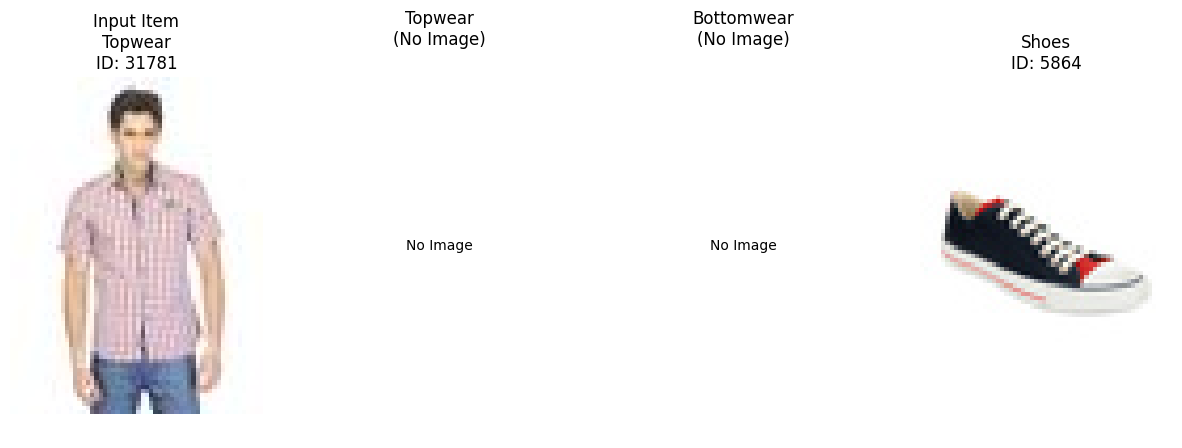

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_images_for_recommendations(item_id, recommendations, df):
    # Get the input item details
    input_item = df[df['id'] == item_id].iloc[0]
    input_img_path = f"/content/your_image_directory/images/{input_item['filename']}"

    # Create a subplot with 1 + len(recommendations) columns
    fig, axes = plt.subplots(1, len(recommendations) + 1, figsize=(15, 5))

    # Display the input item image
    input_img = mpimg.imread(input_img_path)
    axes[0].imshow(input_img)
    axes[0].set_title(f"Input Item\n{input_item['subCategory']}\nID: {item_id}")
    axes[0].axis('off')

    # Display the recommended items images
    for i, (subcategory, rec_id) in enumerate(recommendations):
        if rec_id is not None:
            rec_item = df[df['id'] == rec_id].iloc[0]
            rec_img_path = f"/content/your_image_directory/images/{rec_item['filename']}"
            rec_img = mpimg.imread(rec_img_path)
            axes[i + 1].imshow(rec_img)
            axes[i + 1].set_title(f"{subcategory}\nID: {rec_id}")
        else:
            axes[i + 1].text(0.5, 0.5, 'No Image', horizontalalignment='center', verticalalignment='center')
            axes[i + 1].set_title(f"{subcategory}\n(No Image)")
        axes[i + 1].axis('off')

    plt.show()

# Example usage
show_images_for_recommendations(item_id, recommendations, df)

In [30]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# Step 1: Load the dataset
df = pd.read_csv('/content/drive/MyDrive/Final Fashion Dataset.csv')

# Step 2: Data Preparation
# Selecting relevant columns
data = df[['user_id', 'id', 'ratings']]

# Encoding 'user_id' and 'id' to categorical indices
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

data['user_id'] = user_encoder.fit_transform(data['user_id'])
data['id'] = item_encoder.fit_transform(data['id'])

num_users = data['user_id'].nunique()
num_items = data['id'].nunique()

# Step 3: Train-Test Split
train, test = train_test_split(data, test_size=0.2, random_state=42)

# Step 4: Build the Neural Collaborative Filtering Model
# User Input Network
user_input = Input(shape=(1,))
user_embedding = Embedding(input_dim=num_users, output_dim=50, input_length=1)(user_input)
user_vector = Flatten()(user_embedding)

# Item Input Network
item_input = Input(shape=(1,))
item_embedding = Embedding(input_dim=num_items, output_dim=50, input_length=1)(item_input)
item_vector = Flatten()(item_embedding)

# Concatenate user and item vectors
concatenated = Concatenate()([user_vector, item_vector])
dense_1 = Dense(128, activation='relu')(concatenated)
dropout_1 = Dropout(0.3)(dense_1)
dense_2 = Dense(64, activation='relu')(dropout_1)
dropout_2 = Dropout(0.3)(dense_2)
output = Dense(1)(dropout_2)

# Define the model
model = Model(inputs=[user_input, item_input], outputs=output)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# Model Summary
model.summary()

# Step 5: Train the Model
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(
    [train['user_id'], train['id']], train['ratings'],
    validation_data=([test['user_id'], test['id']], test['ratings']),
    epochs=20, batch_size=64, callbacks=[early_stop]
)

# Step 6: Function to Recommend Outfits
def recommend_outfits(user_id, top_n=5):
    user_index = user_encoder.transform([user_id])[0]
    item_indices = np.arange(num_items)

    # Predict ratings for all items for the given user
    predictions = model.predict([np.array([user_index] * num_items), item_indices])

    # Get top N recommended item indices
    recommended_indices = predictions.flatten().argsort()[-top_n:][::-1]

    # Decode item indices back to original IDs
    recommended_items = item_encoder.inverse_transform(recommended_indices)
    return recommended_items

# Example: Get outfit recommendations for a specific user_id
user_id_to_recommend = 93810  # Example user ID
recommendations = recommend_outfits(user_id_to_recommend, top_n=5)
print(f"Recommended outfits for user {user_id_to_recommend}: {recommendations}")


<ipython-input-30-718dbf1fbd33>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['user_id'] = user_encoder.fit_transform(data['user_id'])
<ipython-input-30-718dbf1fbd33>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['id'] = item_encoder.fit_transform(data['id'])
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 1)              │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 1)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_7 (Embedding)   │ (None, 1, 50)          │        244,550 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_8 (Embedding)   │ (None, 1, 50)          │      1,824,200 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_7 (Flatten)       │ (None, 50)             │              0 │ embedding_7[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 50)             │              0 │ embedding_8[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 100)            │              0 │ flatten_7[0][0],       │
│ (Concatenate)             │                        │                │ flatten_8[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 128)            │         12,928 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 128)            │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 64)             │          8,256 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 64)             │              0 │ dense_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 1)              │             65 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,089,999 (7.97 MB)

 Trainable params: 2,089,999 (7.97 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 5.0646 - mae: 1.7884 - val_loss: 1.6876 - val_mae: 1.1060
Epoch 2/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1.3789 - mae: 0.9472 - val_loss: 1.8756 - val_mae: 1.1522
Epoch 3/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.8202 - mae: 0.7389 - val_loss: 1.7714 - val_mae: 1.1214
Epoch 4/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4629 - mae: 0.5402 - val_loss: 1.7463 - val_mae: 1.1126
Epoch 5/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3971 - mae: 0.5003 - val_loss: 1.7604 - val_mae: 1.1281
Epoch 6/20
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3554 - mae: 0.4666 - val_loss: 1.7478 - val_mae: 1.1252
1141/1141 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Recommended outfits for user 93810: [11203 11144  9560 16817 58257]


In [31]:
pip install requests pillow matplotlib


1141/1141 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
Recommended Outfits:
          id                                 productDisplayName baseColour  \
11004  16817                    Locomotive Men Check Blue Shirt       Blue   
16928  58257                          Baggit Women Maroon Purse     Maroon   
19340  11203  Carrera Men Metal strap Sqaure dial Black Watches      Black   
30037   9560                      Nike Men Tmtsc White T-Shirts      White   
30078  11144              Scullers Men Price Catch Black Shirts      Black   

       Price (USD)  predicted_rating  
11004           54          4.019044  
16928           46          4.000951  
19340           50          3.997036  
30037           44          3.985590  
30078           47          3.980659  

ID: 16817 - Locomotive Men Check Blue Shirt (Color: Blue, Price: $54)


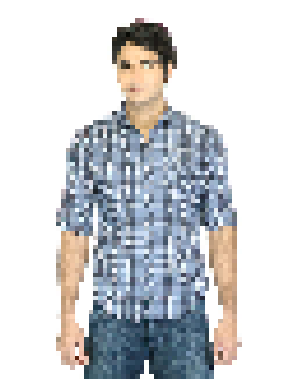


ID: 58257 - Baggit Women Maroon Purse (Color: Maroon, Price: $46)


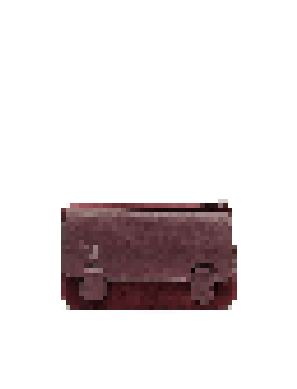


ID: 11203 - Carrera Men Metal strap Sqaure dial Black Watches (Color: Black, Price: $50)


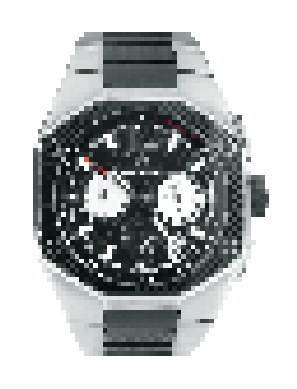


ID: 9560 - Nike Men Tmtsc White T-Shirts (Color: White, Price: $44)


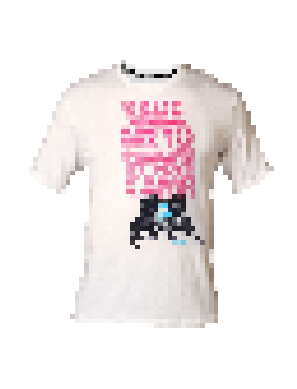


ID: 11144 - Scullers Men Price Catch Black Shirts (Color: Black, Price: $47)


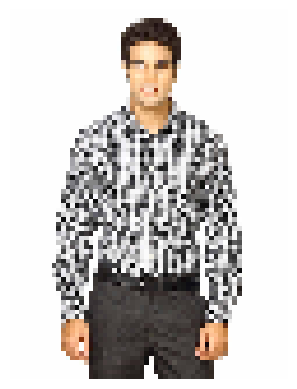

In [36]:
from IPython.display import Image as IPImage, display
import matplotlib.pyplot as plt
import numpy as np
import os
import cv2
from PIL import Image
from io import BytesIO
import requests

# Constants
IMAGE_SIZE = (60, 80)
IMAGE_DIRECTORY = "/content/your_image_directory/images"

# Function to Recommend Outfits with Images
def recommend_outfits_with_images(user_id, top_n=5):
    # Check if the user_id exists in the dataset
    if user_id not in df['user_id'].unique():
        return f"User ID {user_id} not found in the dataset."

    # Convert user_id to encoded index
    user_index = user_encoder.transform([user_id])[0]

    # Create an array of all item indices
    item_indices = np.arange(num_items)

    # Predict ratings for all items for the given user
    predictions = model.predict([np.array([user_index] * num_items), item_indices])

    # Get top N recommended item indices based on predicted ratings
    recommended_indices = predictions.flatten().argsort()[-top_n:][::-1]

    # Decode item indices back to original IDs
    recommended_item_ids = item_encoder.inverse_transform(recommended_indices)

    # Fetch details of the recommended outfits from the original dataset
    recommended_items = df[df['id'].isin(recommended_item_ids)][['id', 'productDisplayName', 'baseColour', 'Price (USD)', 'link', 'filename']]

    # Sort recommendations by predicted ratings
    recommended_items['predicted_rating'] = predictions.flatten()[recommended_indices]

    # Display the recommendations in a tabular format
    print("Recommended Outfits:")
    print(recommended_items[['id', 'productDisplayName', 'baseColour', 'Price (USD)', 'predicted_rating']])

    # Step 7: Display Images of Recommended Items
    for index, row in recommended_items.iterrows():
        print(f"\nID: {row['id']} - {row['productDisplayName']} (Color: {row['baseColour']}, Price: ${row['Price (USD)']})")

        # Process image from link
        if pd.notna(row['link']):
            try:
                response = requests.get(row['link'])
                pil_image = Image.open(BytesIO(response.content)).convert("RGB")
                resized_image = cv2.resize(np.array(pil_image), IMAGE_SIZE)
                # Display resized image
                plt.imshow(resized_image)
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"Could not load image from link: {e}")

        # Process image from local filename
        elif pd.notna(row['filename']):
            try:
                image_path = os.path.join(IMAGE_DIRECTORY, row['filename'])
                pil_image = Image.open(image_path).convert("RGB")
                resized_image = cv2.resize(np.array(pil_image), IMAGE_SIZE)
                # Display resized image
                plt.imshow(resized_image)
                plt.axis('off')
                plt.show()
            except Exception as e:
                print(f"Could not load image from filename: {e}")

# Example: Get outfit recommendations for a specific user_id
user_id_to_recommend = 93810  # Example user ID
recommend_outfits_with_images(user_id_to_recommend, top_n=5)
